#Data Retrieval

In [ ]:
fresno_pm25_df = get_county_pm25_data(fresno_code)

Added data for 1999
Added data for 2000


KeyboardInterrupt: 

# Step 2: Handle Missing Values: make sure that the daily data have consistent daily intervals.

In [ ]:
# Retrieve the AQI value for each unique combination of Date and Monitor location
fresno_pm25_univariate_df = fresno_pm25_df.groupby(['date_local', 'site_number'])['aqi'].mean().reset_index()

In [ ]:
fresno_pm25_univariate_df

,date_local,site_number,aqi
0,1999-01-03,0008,119.0
1,1999-01-03,5001,98.0
2,1999-01-06,0008,115.0
3,1999-01-06,5001,91.0
4,1999-01-09,0008,159.0
...,...,...,...
29422,2025-03-27,0500,23.0
29423,2025-03-28,0500,16.0
29424,2025-03-29,0500,13.0
29425,2025-03-30,0500,17.0


In [ ]:
# Get the average AQI value of all monitors for each day
fresno_pm25_daily_df = fresno_pm25_univariate_df.groupby("date_local")['aqi'].mean().reset_index()

In [ ]:
fresno_pm25_daily_df

,date_local,aqi
0,1999-01-03,108.5
1,1999-01-06,103.0
2,1999-01-09,159.0
3,1999-01-12,165.0
4,1999-01-15,203.0
...,...,...
9196,2025-03-27,23.0
9197,2025-03-28,16.0
9198,2025-03-29,13.0
9199,2025-03-30,17.0


In [ ]:
daily_index = pd.date_range(start="1999-01-01", end="2025-03-31", freq="D")

In [ ]:
# Set the date to datetime type
fresno_pm25_daily_df["date_local"] = pd.to_datetime(fresno_pm25_daily_df["date_local"])

In [ ]:
# set the date_local column to index
fresno_pm25_univariate_df = fresno_pm25_daily_df.set_index("date_local")

# add missing days so that all consecutive days are included
fresno_pm25_univariate_df = fresno_pm25_univariate_df.reindex(daily_index)

In [ ]:
fresno_pm25_univariate_df

,aqi
1999-01-01,NaN
1999-01-02,NaN
1999-01-03,108.5
1999-01-04,NaN
1999-01-05,NaN
...,...
2025-03-27,23.0
2025-03-28,16.0
2025-03-29,13.0
2025-03-30,17.0


In [ ]:
# Fill in the missing values based on nearby days' values; interpolate based on actual time gaps
fresno_pm25_univariate_df["aqi"] = fresno_pm25_univariate_df["aqi"].interpolate(method="time")

In [ ]:
# Fill start and end values
fresno_pm25_univariate_df['aqi'] = fresno_pm25_univariate_df['aqi'].ffill().bfill()

# END of Handling missing values

# Step 3: Detect and Smooth Outliers (interested in typical daily PM 2.5 AQI predictions instead of focusing on rare events)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np

Visualize Before Outlier Smoothing

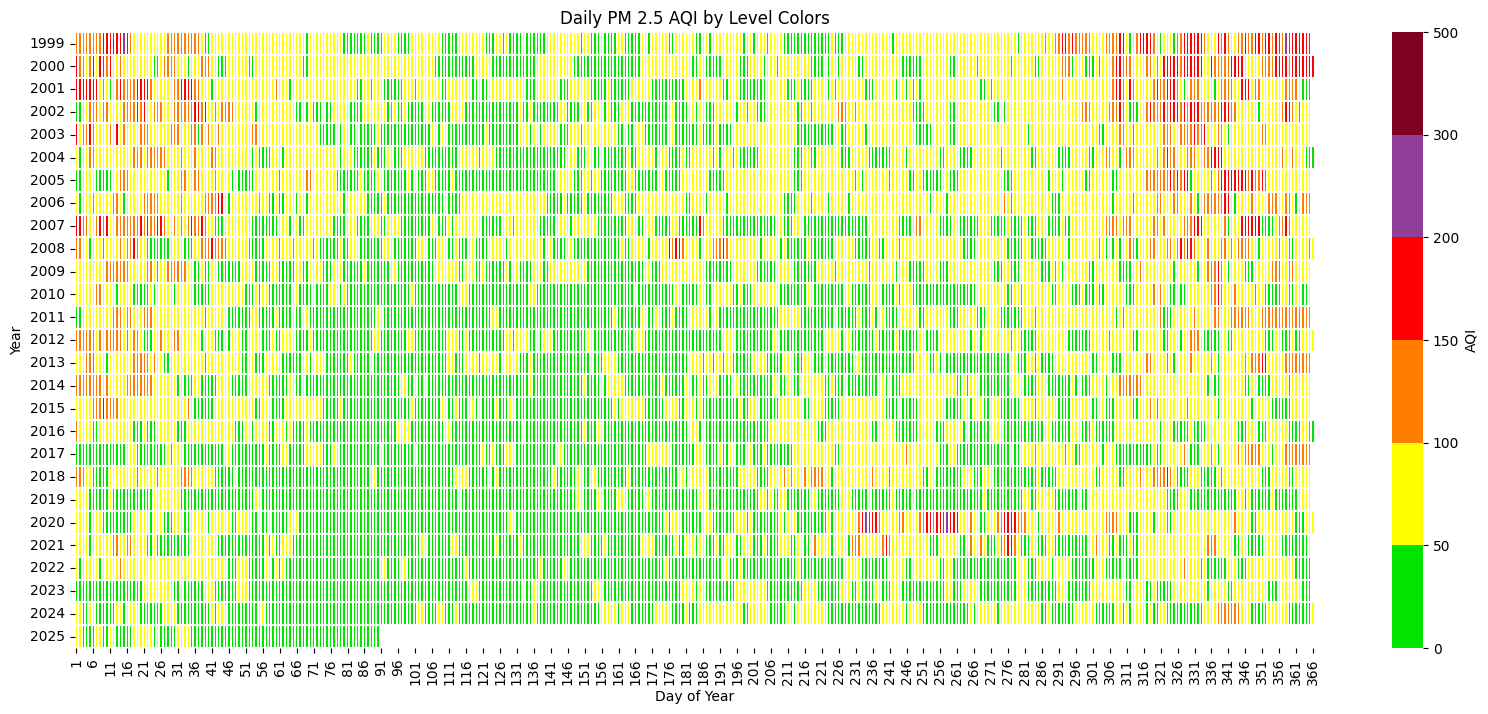

In [ ]:
fresno_pm25_univariate_df['date_local'] = pd.to_datetime(fresno_pm25_univariate_df.index)
fresno_pm25_univariate_df['year'] = fresno_pm25_univariate_df['date_local'].dt.year
fresno_pm25_univariate_df['dayofyear'] = fresno_pm25_univariate_df['date_local'].dt.dayofyear

# Pivot to Year x DayOfYear matrix
pivot_df = fresno_pm25_univariate_df.pivot(index='year', columns='dayofyear', values='aqi')
# Define EPA PM2.5 AQI colors
aqi_colors = ['#00E400', '#FFFF00', '#FF7E00', '#FF0000', '#8F3F97', '#7E0023']

# Define AQI breakpoints
bounds = [0, 50, 100, 150, 200, 300, 500]

# Create custom colormap and norm
cmap = ListedColormap(aqi_colors)
norm = BoundaryNorm(bounds, cmap.N)

# Plot heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(pivot_df, cmap=cmap, norm=norm, cbar_kws={'label': 'AQI'}, linewidths=0.05)

# Customize plot
plt.title('Daily PM 2.5 AQI by Level Colors')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.show()

#Apply Outlier Detection and Smoothing

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
# Reshape AQI values to 2D array
X = fresno_pm25_univariate_df['aqi'].values.reshape(-1, 1)

# Initialize model with the optimal contamination level
model = IsolationForest(contamination=0.05, random_state=42)

# Fit the model
model.fit(X)

# Predict anomalies (-1 for outliers, 1 for inliers)
fresno_pm25_univariate_df['outlier_flag'] = model.predict(X)

In [ ]:
def get_previous_year_aqi(x):
    match = fresno_pm25_univariate_df.loc[
        (fresno_pm25_univariate_df.index.month == x.month) &
        (fresno_pm25_univariate_df.index.day == x.day) &
        (fresno_pm25_univariate_df.index.year == x.year - 1), 'aqi']

    # If there's at least one match, take the mean (or first value)
    if not match.empty:
        return match.mean()  # or match.iloc[0]
    else:
        return np.nan

fresno_pm25_univariate_df['previous_year_aqi'] = fresno_pm25_univariate_df.index.map(get_previous_year_aqi)

In [ ]:
# Replace outliers with previous year AQI values
fresno_pm25_univariate_df['aqi_cleaned'] = fresno_pm25_univariate_df['aqi']
fresno_pm25_univariate_df.loc[fresno_pm25_univariate_df['outlier_flag'] == -1, 'aqi_cleaned'] = fresno_pm25_univariate_df['previous_year_aqi']

# Fill remaining NaNs (where no previous year data exists)
fresno_pm25_univariate_df['aqi_cleaned'].fillna(fresno_pm25_univariate_df['aqi'].median(), inplace=True)

<ipython-input-21-3b25adc1226b>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fresno_pm25_univariate_df['aqi_cleaned'].fillna(fresno_pm25_univariate_df['aqi'].median(), inplace=True)


#Visualize After Outlier Detection and Smoothing

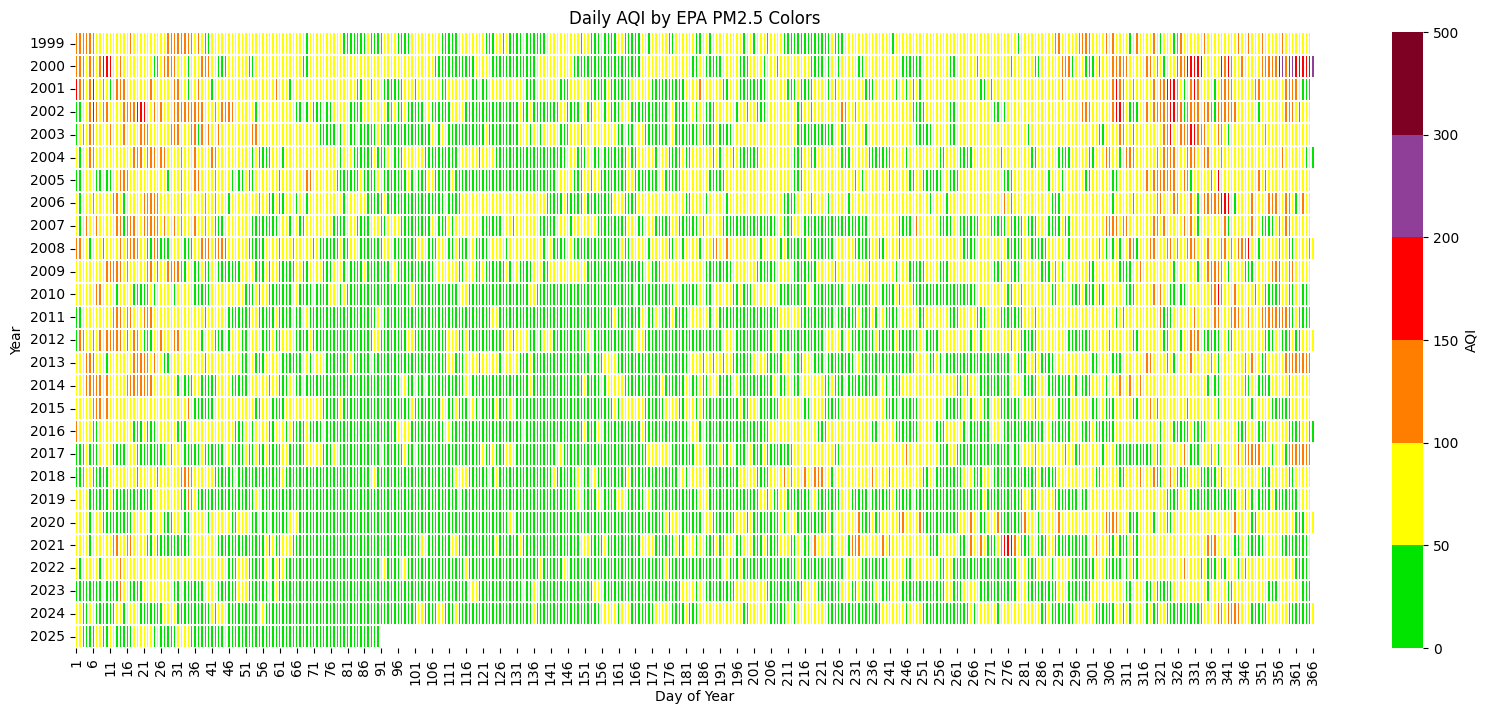

In [ ]:
pivot_df = fresno_pm25_univariate_df.pivot(index='year', columns='dayofyear', values='aqi_cleaned')
# Define EPA PM2.5 AQI colors
aqi_colors = ['#00E400', '#FFFF00', '#FF7E00', '#FF0000', '#8F3F97', '#7E0023']

# Define AQI breakpoints
bounds = [0, 50, 100, 150, 200, 300, 500]

# Create custom colormap and norm
cmap = ListedColormap(aqi_colors)
norm = BoundaryNorm(bounds, cmap.N)

# Plot heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(pivot_df, cmap=cmap, norm=norm, cbar_kws={'label': 'AQI'}, linewidths=0.05)

# Customize plot
plt.title('Daily AQI by EPA PM2.5 Colors')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.show()

#Add Temproal Features


In [ ]:
lstm_df = fresno_pm25_univariate_df[["aqi_cleaned"]]

In [ ]:
lstm_df['day_of_year'] = lstm_df.index.dayofyear
lstm_df['month'] = lstm_df.index.month
lstm_df['day_of_week'] = lstm_df.index.dayofweek
lstm_df['time_index'] = np.arange(len(lstm_df))

<ipython-input-24-ef1d6460f358>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_df['day_of_year'] = lstm_df.index.dayofyear
<ipython-input-24-ef1d6460f358>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_df['month'] = lstm_df.index.month
<ipython-input-24-ef1d6460f358>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
# Day of year (1-365)
lstm_df['day_of_year_sin'] = np.sin(2 * np.pi * lstm_df['day_of_year'] / 365)
lstm_df['day_of_year_cos'] = np.cos(2 * np.pi * lstm_df['day_of_year'] / 365)

# Month (1-12)
lstm_df['month_sin'] = np.sin(2 * np.pi * lstm_df['month'] / 12)
lstm_df['month_cos'] = np.cos(2 * np.pi * lstm_df['month'] / 12)

# Day of week (0-6)
lstm_df['day_of_week_sin'] = np.sin(2 * np.pi * lstm_df['day_of_week'] / 7)
lstm_df['day_of_week_cos'] = np.cos(2 * np.pi * lstm_df['day_of_week'] / 7)

<ipython-input-25-6e716fcc82df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_df['day_of_year_sin'] = np.sin(2 * np.pi * lstm_df['day_of_year'] / 365)


In [ ]:
# drop the raw day, month, week columns
lstm_df.drop(['day_of_year', 'month', 'day_of_week'], axis=1, inplace=True)

In [ ]:
feature_columns = [
    'aqi_cleaned', 'time_index',
    'day_of_year_sin', 'day_of_year_cos',
    'month_sin', 'month_cos',
    'day_of_week_sin', 'day_of_week_cos'
]

# Scale the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(lstm_df[feature_columns])

In [ ]:
data_scaled

array([[4.98777506e-01, 0.00000000e+00, 5.08606758e-01, ...,
        9.33012702e-01, 2.77479066e-01, 0.00000000e+00],
       [4.98777506e-01, 1.04318798e-04, 5.17210965e-01, ...,
        9.33012702e-01, 0.00000000e+00, 3.56895868e-01],
       [4.98777506e-01, 2.08637596e-04, 5.25810073e-01, ...,
        9.33012702e-01, 9.90311321e-02, 8.01937736e-01],
       ...,
       [7.97066015e-02, 9.99791362e-01, 9.99222334e-01, ...,
        5.00000000e-01, 0.00000000e+00, 3.56895868e-01],
       [5.13447433e-02, 9.99895681e-01, 9.99629632e-01, ...,
        5.00000000e-01, 9.90311321e-02, 8.01937736e-01],
       [5.13447433e-02, 1.00000000e+00, 9.99888880e-01, ...,
        5.00000000e-01, 5.00000000e-01, 1.00000000e+00]])

# Create 2 month sequences based Training and Testing Data

In [ ]:
def create_sequences(data, sequence_length, target_column=0):
    X = []
    y = []

    # If data is a DataFrame, just use `data.values` (but here it's already a NumPy array)
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length][target_column])

    return np.array(X), np.array(y)

In [ ]:
# use last 2 months' data
sequence_length = 60
X, y = create_sequences(data_scaled, sequence_length)

# Train the LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Create the improved model
model = Sequential([
    LSTM(96, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),  # Dropout after first LSTM layer
    LSTM(64, return_sequences=False),
    Dropout(0.2),  # Dropout before Dense
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.002541500921444186), loss='mae')  # use MAE instead of MSE

# Train the model
history = model.fit(
    X,
    y,
    epochs=50,  # increase this for better training
    batch_size=32,
    validation_split=0.2,  # use part of training data for validation
    verbose=1,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - loss: 0.0833 - val_loss: 0.0702
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - loss: 0.0663 - val_loss: 0.0510
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 0.0600 - val_loss: 0.0533
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - loss: 0.0574 - val_loss: 0.0479
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - loss: 0.0568 - val_loss: 0.0478
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - loss: 0.0558 - val_loss: 0.0465
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - loss: 0.0554 - val_loss: 0.0473
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - loss: 0.0557 - val_loss: 0.0488
Epoch 9/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - loss: 0.0568 - val_loss: 0.0483


In [ ]:
last_60_scaled = X[-1]

# Predict using the trained model

In [ ]:
import numpy as np
import pandas as pd
from datetime import timedelta

# Start from the last known date
last_date = pd.to_datetime('2025-03-31')
last_time_index = 9586

# Initialize
predictions = []
prediction_dates = []

current_input = last_60_scaled.copy()
current_time_index = last_time_index

for i in range(1460):  # Predict 2 years ahead
    # Predict next AQI
    pred = model.predict(current_input.reshape(1, 60, -1), verbose=0)
    predicted_aqi_scaled = pred[0, 0]
    predictions.append(predicted_aqi_scaled)

    # Update date and time index
    current_time_index += 1
    current_date = last_date + timedelta(days=i + 1)
    prediction_dates.append(current_date)

    # Compute new temporal features
    day_of_year = current_date.timetuple().tm_yday
    day_of_year_sin = np.sin(2 * np.pi * day_of_year / 365)
    day_of_year_cos = np.cos(2 * np.pi * day_of_year / 365)

    month = current_date.month
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)

    day_of_week = current_date.weekday()
    day_of_week_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_of_week_cos = np.cos(2 * np.pi * day_of_week / 7)

    # Normalize time_index using the same scaler as during training
    time_features = np.array([[0, current_time_index, day_of_year_sin, day_of_year_cos,
                               month_sin, month_cos, day_of_week_sin, day_of_week_cos]])
    time_features_scaled = scaler.transform(time_features)
    time_features_scaled[0, 0] = predicted_aqi_scaled  # replace dummy AQI with predicted one

    # Add to the sequence
    current_input = np.append(current_input[1:], [time_features_scaled[0]], axis=0)

# Inverse transform only AQI predictions
aqi_predictions_scaled = np.array(predictions).reshape(-1, 1)
aqi_predictions = scaler.inverse_transform(
    np.hstack([aqi_predictions_scaled, np.zeros((len(aqi_predictions_scaled), scaler.n_features_in_ - 1))])
)[:, 0]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the Predictions

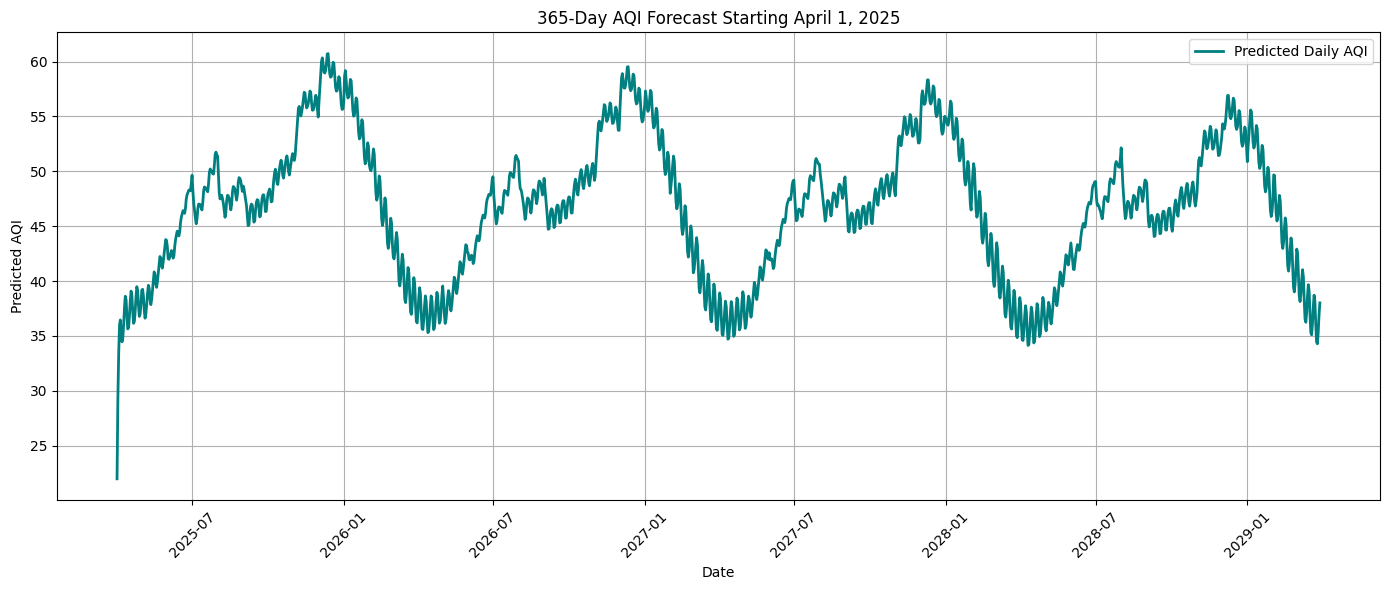

In [ ]:
# Generate date range starting from April 1, 2025
start_date = pd.to_datetime("2025-04-01")
dates = pd.date_range(start=start_date, periods=len(predictions))

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(dates, aqi_predictions, label='Predicted Daily AQI', color='teal', linewidth=2)
plt.xlabel("Date")
plt.ylabel("Predicted AQI")
plt.title("365-Day AQI Forecast Starting April 1, 2025")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

plt.show()

# Save the Model, Scaler, and the Last 60 Days' Training Data for Production Level Use

In [ ]:
import joblib
import numpy as np

model.save('rigorous_fresno_pm25_lstm_model.h5')
np.save('rigorous_fresno_pm25_last_60_scaled.npy', last_60_scaled)
joblib.dump(scaler, 'rigorous_fresno_pm25_scaler.pkl')


['rigorous_fresno_pm25_scaler.pkl']